Defining an "adopted user" as a user who has logged into the product on three separate
days in at least one sevenday
period , identify which factors predict future user
adoption .

### Analaysis

Of 12,000 user accounts 13.35% of users are adopted users. Of the 12,000 user accounts 8,823 have logged on at least once. Of the 8,823 users that have logged in at least once 18.16% or 1602 users are adopted. 

During the ETL phase of this analysis my first step was to address the missing values in last_session_creation_time and invited_by_user_id. NaN values in the last_session_creation_time column, I assumed to represent users that had never logged on, thus filling with 0s made sense. For NaN values in the invited_by_user_id column, I assumed NaN values represented users that were not invited to the application and thus filling with 0s again made snse. 

For the feature engineering and selection phase I started by dropping the name field. I elected to transform the email field into seven hot one encoded categories representing the top 6 most popular email domains and then a 7th category representing other. I also hot one encoded creation source. For creation_time, I split it out into a number of sub-time categories such as year, month, weekday number, etc. 

For the EDA portion I visualized proportion of adopted users by year of account creation and by month of account creation. I also looked at the count of most recent user logins by week increment for adopted users verse non-adopted users. 

Non-adopted users have a more uniform distribution of most recent user logins across the past two years whereas the vast majority of adopted users have a most recent login time in the last week or two. This makes sense as adopted users that have not churned are continuing to use the product and have thus logged in recently. 

Users that created their account from June through December were more likely to become an adopted user and users that created their account in April or May were far less likely to become an adopted user. 

For the model building portion of the analysis I elected to use a Random Forest Classifier, because it is robust against class imbalances and because it has a feature importance method. 

After model tuning the train accuracy was 96.4% and the test accuracy was 95.6% with an AUC of .97. Upon running feature importance I recognized that last_session_creation_itme was by far the most important feature. I decided to rerun the model with this feature dropped, because this new model wouldn't require knowing whether the user had already logged in or if it was in the last week. This model might provide more explanatory value to what user characteristics leads to adoption aside from having logged in recently. 

This model produced a lower train and test accuracy of roughly 87% for both and an AUC of .64. If trying to predict user adoption I would use the first model. Having said that, I believe the more important goal is assessing what user characteristics lead to adoption. For this final analysis I will use the second model's feature importance table.

The most important feature is organization ID. This would suggest that some companies or organizations use the software as an essential tool. The second most important feature is user ID. Given that each user ID is only represented once and login data was not included in the model, the numeric ordering of user ID which is related to the order in which users signed up must be relevant to adoption rate. The second and third following most important features: hour of account creation and month of account creation confirm the hypothesis that account creationg time impacts adoption rate. The next feature by importance is invited_by_user_id which suggests users invited by a friend or colleague are more likely to adopt. Also in the top 10 features is opted_in_to_mailing_list which would suggest higher user engagement and thus likelihood to be adopted. 

Given these features, I would recomend managmenet of Relax increase user adoption by attempted to get the software adopted by an organization as oppose to on a user by user basis. How to get organizational adoption is a different problem, but could involve working with the organizations upper managmeent or IT team as oppose to attempting to interface with individual users. Another recomendation would be to incentive current users to invite colleagues and friends to the software. 

In [1]:
import pandas as pd
from datetime import timedelta
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import SGDRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
import datetime
from sklearn.utils import resample
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
import collections
import seaborn as sns

In [2]:
users = pd.read_csv('takehome_users.csv', encoding='latin-1')

In [3]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
object_id                     12000 non-null int64
creation_time                 12000 non-null object
name                          12000 non-null object
email                         12000 non-null object
creation_source               12000 non-null object
last_session_creation_time    8823 non-null float64
opted_in_to_mailing_list      12000 non-null int64
enabled_for_marketing_drip    12000 non-null int64
org_id                        12000 non-null int64
invited_by_user_id            6417 non-null float64
dtypes: float64(2), int64(4), object(4)
memory usage: 937.6+ KB


In [4]:
users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [5]:
usage =  pd.read_csv('takehome_user_engagement.csv',encoding='latin-1')

In [6]:
usage.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
time_stamp    207917 non-null object
user_id       207917 non-null int64
visited       207917 non-null int64
dtypes: int64(2), object(1)
memory usage: 4.8+ MB


In [7]:
usage.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [8]:
combined = users.merge(usage, left_on='object_id', right_on='user_id')

In [9]:
combined.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 207917 entries, 0 to 207916
Data columns (total 13 columns):
object_id                     207917 non-null int64
creation_time                 207917 non-null object
name                          207917 non-null object
email                         207917 non-null object
creation_source               207917 non-null object
last_session_creation_time    207917 non-null float64
opted_in_to_mailing_list      207917 non-null int64
enabled_for_marketing_drip    207917 non-null int64
org_id                        207917 non-null int64
invited_by_user_id            116887 non-null float64
time_stamp                    207917 non-null object
user_id                       207917 non-null int64
visited                       207917 non-null int64
dtypes: float64(2), int64(6), object(5)
memory usage: 22.2+ MB


In [10]:
combined.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,time_stamp,user_id,visited
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,2014-04-22 03:53:30,1,1
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,2013-11-15 03:45:04,2,1
2,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,2013-11-29 03:45:04,2,1
3,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,2013-12-09 03:45:04,2,1
4,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,2013-12-25 03:45:04,2,1


In [11]:
print('Number of users signed in at least once: ', len(set(combined.user_id.values)))
print('Number of users that created at account', len(users))

Number of users signed in at least once:  8823
Number of users that created at account 12000


In [12]:
# sort dataframe by user_id and then order of login
combined.sort_values(['user_id','time_stamp'])
combined

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,time_stamp,user_id,visited
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,2014-04-22 03:53:30,1,1
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,2013-11-15 03:45:04,2,1
2,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,2013-11-29 03:45:04,2,1
3,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,2013-12-09 03:45:04,2,1
4,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,2013-12-25 03:45:04,2,1
5,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,2013-12-31 03:45:04,2,1
6,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,2014-01-08 03:45:04,2,1
7,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,2014-02-03 03:45:04,2,1
8,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,2014-02-08 03:45:04,2,1
9,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,2014-02-09 03:45:04,2,1


In [41]:
# Creates a list of all users that are considered adopted
adopted = []
adopted_user = 0

end = len(combined)-2
for index, row in combined.iterrows():
    if index == end:
        break
    
    user_id_1 = row[0]
    user_date_1 = pd.to_datetime(row[10])
    
    if user_id_1 == adopted_user:
        continue
    
    user_id_2 = combined.iloc[index+1,:][0]
    user_date_2 = pd.to_datetime(combined.iloc[index+1,:][10])
    
    user_id_3 = combined.iloc[index+2,:][0]
    user_date_3 = pd.to_datetime(combined.iloc[index+2,:][10])

    
    if (user_id_1 == user_id_2) and (user_id_1 == user_id_3):
        if ((user_date_2 - user_date_1) < timedelta(days=7)) and ((user_date_3 - user_date_1) < timedelta(days=7)): 
            adopted.append(user_id_1)
            adopted_user = user_id_1
            
 

In [42]:
print('Number of users that have been adopted: ', len(adopted))

Number of users that have been adopted:  1602


In [43]:
print('Percentage of all accounts that are adopted users: %', 100* (len(adopted) / len(users)))
print('Percentage of accounts that have logged in at least once that are adopted users: %', 100* (len(adopted) / len(set(combined.user_id.values))))

Percentage of all accounts that are adopted users: % 13.350000000000001
Percentage of accounts that have logged in at least once that are adopted users: % 18.157089425365523


In [44]:
users['adopted'] = 0

In [45]:
# Sets adopted column to 1 if user was adopted
users['adopted'] = 0
for index, row in users.iterrows():
    if row[0] in adopted:
        print('adopted')
        users.iloc[index, 10] = 1

adopted
adopted
adopted
adopted
adopted
adopted
adopted
adopted
adopted
adopted
adopted
adopted
adopted
adopted
adopted
adopted
adopted
adopted
adopted
adopted
adopted
adopted
adopted
adopted
adopted
adopted
adopted
adopted
adopted
adopted
adopted
adopted
adopted
adopted
adopted
adopted
adopted
adopted
adopted
adopted
adopted
adopted
adopted
adopted
adopted
adopted
adopted
adopted
adopted
adopted
adopted
adopted
adopted
adopted
adopted
adopted
adopted
adopted
adopted
adopted
adopted
adopted
adopted
adopted
adopted
adopted
adopted
adopted
adopted
adopted
adopted
adopted
adopted
adopted
adopted
adopted
adopted
adopted
adopted
adopted
adopted
adopted
adopted
adopted
adopted
adopted
adopted
adopted
adopted
adopted
adopted
adopted
adopted
adopted
adopted
adopted
adopted
adopted
adopted
adopted
adopted
adopted
adopted
adopted
adopted
adopted
adopted
adopted
adopted
adopted
adopted
adopted
adopted
adopted
adopted
adopted
adopted
adopted
adopted
adopted
adopted
adopted
adopted
adopted
adopted


adopted
adopted
adopted
adopted
adopted
adopted
adopted
adopted
adopted
adopted
adopted
adopted
adopted
adopted
adopted
adopted
adopted
adopted
adopted
adopted
adopted
adopted
adopted
adopted
adopted
adopted
adopted
adopted
adopted
adopted
adopted
adopted
adopted
adopted
adopted
adopted
adopted
adopted
adopted
adopted
adopted
adopted
adopted
adopted
adopted
adopted
adopted
adopted
adopted
adopted
adopted
adopted
adopted
adopted
adopted
adopted
adopted
adopted
adopted
adopted
adopted
adopted
adopted
adopted
adopted
adopted
adopted
adopted
adopted
adopted
adopted
adopted
adopted
adopted
adopted
adopted
adopted
adopted
adopted
adopted
adopted
adopted
adopted
adopted
adopted
adopted
adopted
adopted
adopted
adopted
adopted
adopted
adopted
adopted
adopted
adopted
adopted
adopted
adopted
adopted
adopted
adopted
adopted
adopted
adopted
adopted
adopted
adopted
adopted
adopted
adopted
adopted
adopted
adopted
adopted
adopted
adopted
adopted
adopted
adopted
adopted
adopted
adopted
adopted
adopted


In [46]:
y = users.adopted
x = users.drop(['adopted', 'name'], axis=1)

In [47]:
# creates hot one encoding for the top 6 email domains and classifies all other domains as other
x['email'] = x.email.apply(lambda x: x.split('@')[1])
ec = collections.Counter()
ec.update(x.email.values)
top_6 = dict(ec.most_common(6))
t6 = list(top_6.keys())
x['email'] = x['email'].apply(lambda y: y if y in t6 else 'other')

In [48]:
# fills last_session_creat_time and invited_by_user_id nans to 0 which 
# makes sense. For last_session_creat_time if the value is Nan
# then the user never logged in and 0 makes sense. For invited_by_user_id
# if the value is Nan the user was not invited and 0 again makes sense.
x = x.fillna(0)

In [49]:
# creation of a year, month, weekday, weekend, business-day and hour column based on 
# creation of the account time
x.creation_time = x.creation_time.apply(lambda z: pd.to_datetime(z))
x['year'] = x['creation_time'].dt.year
x['month'] = x['creation_time'].dt.month
x['weekday_num'] = x['creation_time'].dt.weekday
x['weekend'] = x.weekday_num.apply(lambda y: 1 if y > 5 else 0)
x['business_day'] = x.weekday_num.apply(lambda y: 1 if y < 6 else 0)
x['hour'] = x.creation_time.dt.hour

In [50]:
# hot one encode the create_source and email domain columns
cs = pd.get_dummies(x.creation_source)
x = pd.concat([x, cs],axis=1)

email = pd.get_dummies(x.email)
x = pd.concat([x, email],axis=1)

In [51]:
# drops unnecesary columns
x.drop('creation_source',axis=1, inplace=True)
x.drop('creation_time',axis=1, inplace=True)
x.drop('email',axis=1, inplace=True)

In [84]:
# Creates a dataframe combining features with target for plotting
plot = pd.concat([x, y], axis=1)

In [85]:
from datetime import datetime

In [86]:
plot.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 25 columns):
object_id                     12000 non-null int64
last_session_creation_time    12000 non-null float64
opted_in_to_mailing_list      12000 non-null int64
enabled_for_marketing_drip    12000 non-null int64
org_id                        12000 non-null int64
invited_by_user_id            12000 non-null float64
year                          12000 non-null int64
month                         12000 non-null int64
weekday_num                   12000 non-null int64
weekend                       12000 non-null int64
business_day                  12000 non-null int64
hour                          12000 non-null int64
GUEST_INVITE                  12000 non-null uint8
ORG_INVITE                    12000 non-null uint8
PERSONAL_PROJECTS             12000 non-null uint8
SIGNUP                        12000 non-null uint8
SIGNUP_GOOGLE_AUTH            12000 non-null uint8
cuvox.de            

In [87]:
# converts last_session_creation_time unix time stamp to datetime
plot.last_session_creation_time = plot.last_session_creation_time.apply(lambda y: datetime.fromtimestamp((y)))

In [88]:
# drops non-existent last_session_creation time records
plot2 = plot[plot.last_session_creation_time > pd.to_datetime(1970)]

In [89]:
plot2['count'] = 0
plot2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8823 entries, 0 to 11999
Data columns (total 26 columns):
object_id                     8823 non-null int64
last_session_creation_time    8823 non-null datetime64[ns]
opted_in_to_mailing_list      8823 non-null int64
enabled_for_marketing_drip    8823 non-null int64
org_id                        8823 non-null int64
invited_by_user_id            8823 non-null float64
year                          8823 non-null int64
month                         8823 non-null int64
weekday_num                   8823 non-null int64
weekend                       8823 non-null int64
business_day                  8823 non-null int64
hour                          8823 non-null int64
GUEST_INVITE                  8823 non-null uint8
ORG_INVITE                    8823 non-null uint8
PERSONAL_PROJECTS             8823 non-null uint8
SIGNUP                        8823 non-null uint8
SIGNUP_GOOGLE_AUTH            8823 non-null uint8
cuvox.de                      8

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [90]:
y = plot2[plot2.adopted == 1]
n = plot2[plot2.adopted == 0]

In [91]:
# Count of last_session_creation_times per hour
y = y.set_index('last_session_creation_time').groupby(pd.TimeGrouper('7d')).count()
n = n.set_index('last_session_creation_time').groupby(pd.TimeGrouper('7d')).count()

In [92]:
y = y.reset_index()
index = y.index.values.astype(str)
y.reset_index(index)

/anaconda/lib/python3.6/site-packages/pandas/core/frame.py:3055: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if level is None or i in level:


,last_session_creation_time,object_id,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,year,month,weekday_num,weekend,...,SIGNUP_GOOGLE_AUTH,cuvox.de,gmail.com,gustr.com,hotmail.com,jourrapide.com,other,yahoo.com,adopted,count
0,2012-07-06 09:46:16,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
1,2012-07-13 09:46:16,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
2,2012-07-20 09:46:16,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2012-07-27 09:46:16,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2012-08-03 09:46:16,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,2012-08-10 09:46:16,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
6,2012-08-17 09:46:16,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
7,2012-08-24 09:46:16,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,2012-08-31 09:46:16,3,3,3,3,3,3,3,3,3,...,3,3,3,3,3,3,3,3,3,3
9,2012-09-07 09:46:16,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2


In [93]:
n = n.reset_index()
index = n.index.values.astype(str)
n.reset_index(index)

/anaconda/lib/python3.6/site-packages/pandas/core/frame.py:3055: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if level is None or i in level:


,last_session_creation_time,object_id,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,year,month,weekday_num,weekend,...,SIGNUP_GOOGLE_AUTH,cuvox.de,gmail.com,gustr.com,hotmail.com,jourrapide.com,other,yahoo.com,adopted,count
0,2012-05-31 04:20:06,35,35,35,35,35,35,35,35,35,...,35,35,35,35,35,35,35,35,35,35
1,2012-06-07 04:20:06,45,45,45,45,45,45,45,45,45,...,45,45,45,45,45,45,45,45,45,45
2,2012-06-14 04:20:06,45,45,45,45,45,45,45,45,45,...,45,45,45,45,45,45,45,45,45,45
3,2012-06-21 04:20:06,52,52,52,52,52,52,52,52,52,...,52,52,52,52,52,52,52,52,52,52
4,2012-06-28 04:20:06,55,55,55,55,55,55,55,55,55,...,55,55,55,55,55,55,55,55,55,55
5,2012-07-05 04:20:06,39,39,39,39,39,39,39,39,39,...,39,39,39,39,39,39,39,39,39,39
6,2012-07-12 04:20:06,39,39,39,39,39,39,39,39,39,...,39,39,39,39,39,39,39,39,39,39
7,2012-07-19 04:20:06,67,67,67,67,67,67,67,67,67,...,67,67,67,67,67,67,67,67,67,67
8,2012-07-26 04:20:06,48,48,48,48,48,48,48,48,48,...,48,48,48,48,48,48,48,48,48,48
9,2012-08-02 04:20:06,44,44,44,44,44,44,44,44,44,...,44,44,44,44,44,44,44,44,44,44


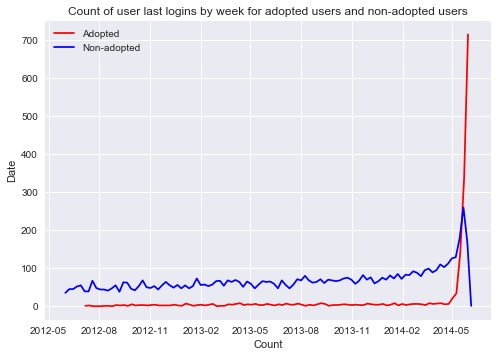

In [97]:
plt.plot(y.last_session_creation_time, y['count'], color='r')
plt.plot(n.last_session_creation_time, n['count'], color='b')
plt.legend(['Adopted', 'Non-adopted'])
plt.title('Count of user last logins by week for adopted users and non-adopted users')
plt.xlabel('Count')
plt.ylabel('Date')
plt.show()

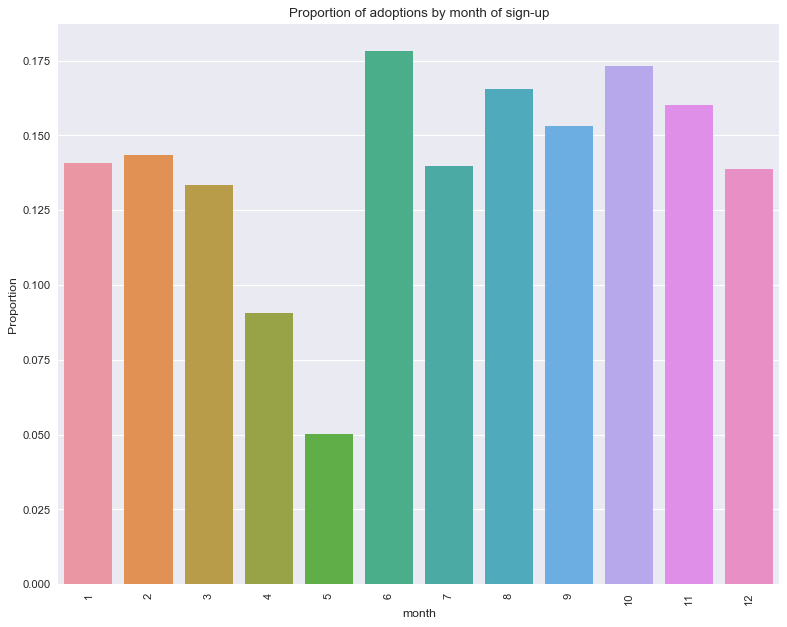

In [512]:
a = pd.crosstab(plot.month, plot.adopted, normalize='index').sort_values(1).reset_index()

plt.gcf().clear()

fig = plt.figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
sns.barplot(x='month', y=1, data=a)

plt.title('Proportion of adoptions by month of sign-up')
plt.ylabel('Proportion')
plt.xticks(rotation='vertical')


plt.tight_layout()
plt.show()

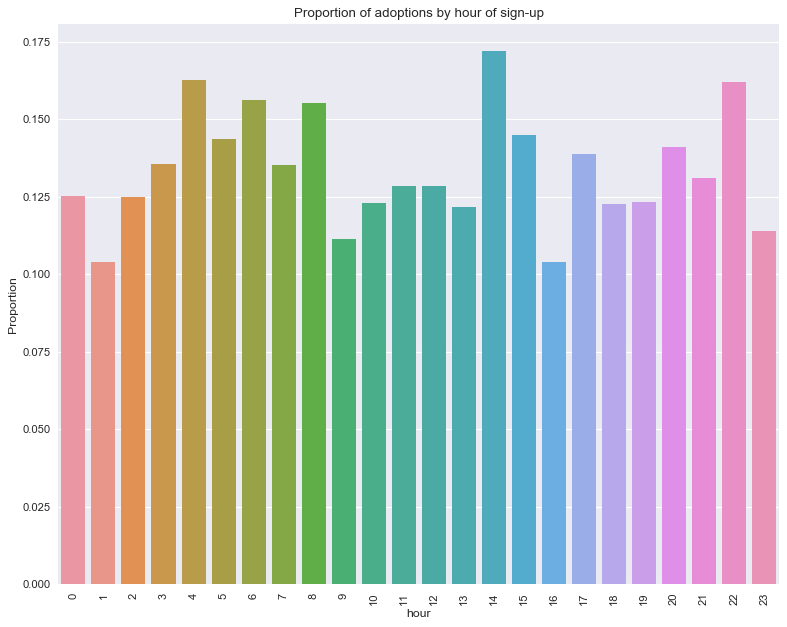

In [432]:
a = pd.crosstab(plot.hour, plot.adopted, normalize='index').sort_values(1).reset_index()

plt.gcf().clear()

fig = plt.figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
sns.barplot(x='hour', y=1, data=a)

plt.title('Proportion of adoptions by hour of sign-up')
plt.ylabel('Proportion')
plt.xticks(rotation='vertical')


plt.tight_layout()
plt.show()

In [451]:
yes = plot[plot.adopted == 1]
no = yes = plot[plot.adopted == 0]

In [455]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 11 columns):
object_id                     12000 non-null int64
creation_time                 12000 non-null object
name                          12000 non-null object
email                         12000 non-null object
creation_source               12000 non-null object
last_session_creation_time    8823 non-null float64
opted_in_to_mailing_list      12000 non-null int64
enabled_for_marketing_drip    12000 non-null int64
org_id                        12000 non-null int64
invited_by_user_id            6417 non-null float64
adopted                       12000 non-null int64
dtypes: float64(2), int64(5), object(4)
memory usage: 1.0+ MB


In [397]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = .3, random_state=42)

In [398]:
rfc = RandomForestClassifier(random_state=0)

In [399]:
rfc.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [401]:
importance = list(rfc.feature_importances_)
feature = list(X_train.columns)

feature_importance = pd.DataFrame({'Feature': feature, 'Importance': importance})

print('Feature importance determined from random forest')
print(feature_importance.sort_values('Importance', ascending=False))

Feature importance determined from random forest
                       Feature  Importance
1   last_session_creation_time    0.577507
7                        month    0.072182
4                       org_id    0.064358
0                    object_id    0.057729
11                        hour    0.043273
6                         year    0.039299
5           invited_by_user_id    0.036475
8                  weekday_num    0.025932
3   enabled_for_marketing_drip    0.008614
2     opted_in_to_mailing_list    0.008172
12                GUEST_INVITE    0.005970
14           PERSONAL_PROJECTS    0.005935
13                  ORG_INVITE    0.005926
18                   gmail.com    0.005915
23                   yahoo.com    0.005719
22                       other    0.004432
15                      SIGNUP    0.004402
19                   gustr.com    0.004367
21              jourrapide.com    0.004323
10                business_day    0.004236
9                      weekend    0.004077
16   

In [402]:
train_score = rfc.score(X_train, y_train)
print("Train: {}".format(train_score))

test_score = rfc.score(X_test, y_test)
print("Test: {}".format(test_score))

Train: 0.9944047619047619
Test: 0.9541666666666667


In [403]:
# Running random search on RFC
print('Starting random search on RFC at: ', datetime.datetime.now())

param_grid = { 
              "n_estimators": np.arange(300, 400, 10),
              "max_features" : ['auto'],
              "min_samples_leaf": np.arange(7,13,1),
              'max_depth' : np.arange(25, 55, 5)
}

rfc = RandomForestClassifier(n_jobs=-1, oob_score= True, random_state = 0)
print('classifier substantiated')
    
CV_rfr = RandomizedSearchCV(estimator=rfc, param_distributions=param_grid, cv=3)
print('search substantiated')
    
print("Start random fit: ", datetime.datetime.now())
CV_rfr.fit(X_train, y_train)
print("End random fit: ", datetime.datetime.now())

print('Best Params: ', CV_rfr.best_params_)
bp = CV_rfr.best_params_ # best parameters

rfc = RandomForestClassifier(
n_estimators = bp['n_estimators'], 
max_features= bp['max_features'],
min_samples_leaf= bp['min_samples_leaf'], 
max_depth=bp['max_depth'])
    
print('Classifier with best parameters set')
     
print("Start rfr fit: ", datetime.datetime.now())
rfc.fit(X_train, y_train)
print("End rfr fit: ", datetime.datetime.now())

train_score = rfc.score(X_train, y_train)
print("Train: {}".format(train_score))

test_score = rfc.score(X_test, y_test)
print("Test: {}".format(test_score))

print('Ending random search on RFR at: ', datetime.datetime.now())

# ROC curve calculations
probs = rfc.predict_proba(X_test)
preds = probs[:,1]
fpr_rfc, tpr_rfc, threshold_rfc = roc_curve(y_test, preds)
roc_auc_rfc = auc(fpr_rfc, tpr_rfc)

Starting random search on RFC at:  2018-04-30 20:29:22.733555
classifier substantiated
search substantiated
Start random fit:  2018-04-30 20:29:22.739526
End random fit:  2018-04-30 20:30:17.763661
Best Params:  {'n_estimators': 340, 'min_samples_leaf': 7, 'max_features': 'auto', 'max_depth': 35}
Classifier with best parameters set
Start rfr fit:  2018-04-30 20:30:17.765199
End rfr fit:  2018-04-30 20:30:20.580494
Train: 0.9648809523809524
Test: 0.9566666666666667
Ending random search on RFR at:  2018-04-30 20:30:21.117467


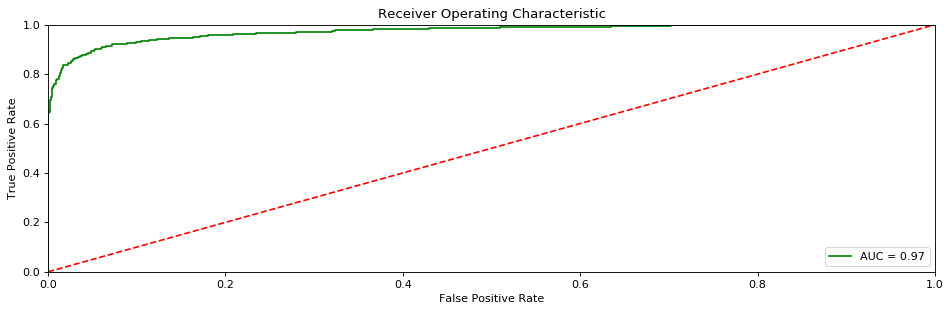

In [404]:
plt.gcf().clear()

plt.figure(num=None, figsize=(12, 4), dpi=80, facecolor='w', edgecolor='k')

plt.title('Receiver Operating Characteristic')
plt.plot(fpr_rfc, tpr_rfc, 'g', label = 'AUC = %0.2f' % roc_auc_rfc)

plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

plt.tight_layout()
plt.show()

In [223]:
importance = list(rfc.feature_importances_)
feature = list(X_train.columns)

feature_importance = pd.DataFrame({'Feature': feature, 'Importance': importance})

print('Feature importance determined from random forest')
print(feature_importance.sort_values('Importance', ascending=False))

Feature importance determined from random forest
                       Feature  Importance
1   last_session_creation_time    0.873494
4                       org_id    0.042179
0                    object_id    0.039503
5           invited_by_user_id    0.024449
8                           pp    0.005353
2     opted_in_to_mailing_list    0.003339
6                 GUEST_INVITE    0.002773
3   enabled_for_marketing_drip    0.002747
7                   ORG_INVITE    0.002468
10          SIGNUP_GOOGLE_AUTH    0.001953
9                       SIGNUP    0.001743


In [405]:
X_train_no_ls = X_train.drop('last_session_creation_time', axis=1)
X_test_no_ls = X_test.drop('last_session_creation_time', axis=1)

In [406]:
# Running random search on RFC
print('Starting random search on RFC at: ', datetime.datetime.now())

param_grid = { 
              "n_estimators": np.arange(300, 400, 10),
              "max_features" : ['auto'],
              "min_samples_leaf": np.arange(7,13,1),
              'max_depth' : np.arange(25, 55, 5)
}

rfc = RandomForestClassifier(n_jobs=-1, oob_score= True, random_state = 0)
print('classifier substantiated')
    
CV_rfr = RandomizedSearchCV(estimator=rfc, param_distributions=param_grid, cv=3)
print('search substantiated')
    
print("Start random fit: ", datetime.datetime.now())
CV_rfr.fit(X_train_no_ls, y_train)
print("End random fit: ", datetime.datetime.now())

print('Best Params: ', CV_rfr.best_params_)
bp = CV_rfr.best_params_ # best parameters

rfc = RandomForestClassifier(
n_estimators = bp['n_estimators'], 
max_features= bp['max_features'],
min_samples_leaf= bp['min_samples_leaf'], 
max_depth=bp['max_depth'])
    
print('Classifier with best parameters set')
     
print("Start rfr fit: ", datetime.datetime.now())
rfc.fit(X_train_no_ls, y_train)
print("End rfr fit: ", datetime.datetime.now())

train_score = rfc.score(X_train_no_ls, y_train)
print("Train: {}".format(train_score))

test_score = rfc.score(X_test_no_ls, y_test)
print("Test: {}".format(test_score))

print('Ending random search on RFR at: ', datetime.datetime.now())

# ROC curve calculations
probs = rfc.predict_proba(X_test_no_ls)
preds = probs[:,1]
fpr_rfc, tpr_rfc, threshold_rfc = roc_curve(y_test, preds)
roc_auc_rfc = auc(fpr_rfc, tpr_rfc)

Starting random search on RFC at:  2018-04-30 20:34:38.606508
classifier substantiated
search substantiated
Start random fit:  2018-04-30 20:34:38.610296
End random fit:  2018-04-30 20:35:32.712399
Best Params:  {'n_estimators': 320, 'min_samples_leaf': 9, 'max_features': 'auto', 'max_depth': 45}
Classifier with best parameters set
Start rfr fit:  2018-04-30 20:35:32.713303
End rfr fit:  2018-04-30 20:35:35.099408
Train: 0.8671428571428571
Test: 0.865
Ending random search on RFR at:  2018-04-30 20:35:35.658537


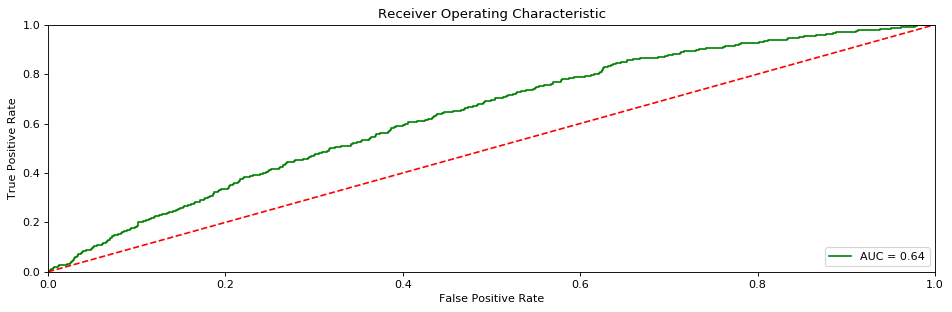

In [407]:
plt.gcf().clear()

plt.figure(num=None, figsize=(12, 4), dpi=80, facecolor='w', edgecolor='k')

plt.title('Receiver Operating Characteristic')
plt.plot(fpr_rfc, tpr_rfc, 'g', label = 'AUC = %0.2f' % roc_auc_rfc)

plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

plt.tight_layout()
plt.show()

In [443]:
importance = list(rfc.feature_importances_)
feature = list(X_train_no_ls.columns)

feature_importance = pd.DataFrame({'Feature': feature, 'Importance': importance})

print('Feature importance determined from random forest')
print(feature_importance.sort_values('Importance', ascending=False))

Feature importance determined from random forest
                       Feature  Importance
3                       org_id    0.186616
0                    object_id    0.165049
10                        hour    0.118973
6                        month    0.113759
4           invited_by_user_id    0.107144
7                  weekday_num    0.066535
5                         year    0.053366
13           PERSONAL_PROJECTS    0.024401
1     opted_in_to_mailing_list    0.017252
17                   gmail.com    0.015206
11                GUEST_INVITE    0.014720
12                  ORG_INVITE    0.013990
22                   yahoo.com    0.013181
2   enabled_for_marketing_drip    0.012671
14                      SIGNUP    0.011269
19                 hotmail.com    0.010941
15          SIGNUP_GOOGLE_AUTH    0.010074
20              jourrapide.com    0.008602
21                       other    0.008068
18                   gustr.com    0.007400
9                 business_day    0.007255
16   